Loading data...

Initializing text vectorizer...

Processing training data in batches...

Processing test data...

Splitting data for validation...

Training model...

Evaluating model...

Validation Metrics:
Accuracy: 0.5789967987235288

Classification Report:
              precision    recall  f1-score   support

         1.0       0.49      0.30      0.37     18074
         2.0       0.47      0.01      0.02     17604
         3.0       0.42      0.10      0.17     35179
         4.0       0.39      0.21      0.27     67127
         5.0       0.62      0.94      0.74    159085

    accuracy                           0.58    297069
   macro avg       0.48      0.31      0.31    297069
weighted avg       0.53      0.58      0.50    297069


Making predictions...

Submission file created!


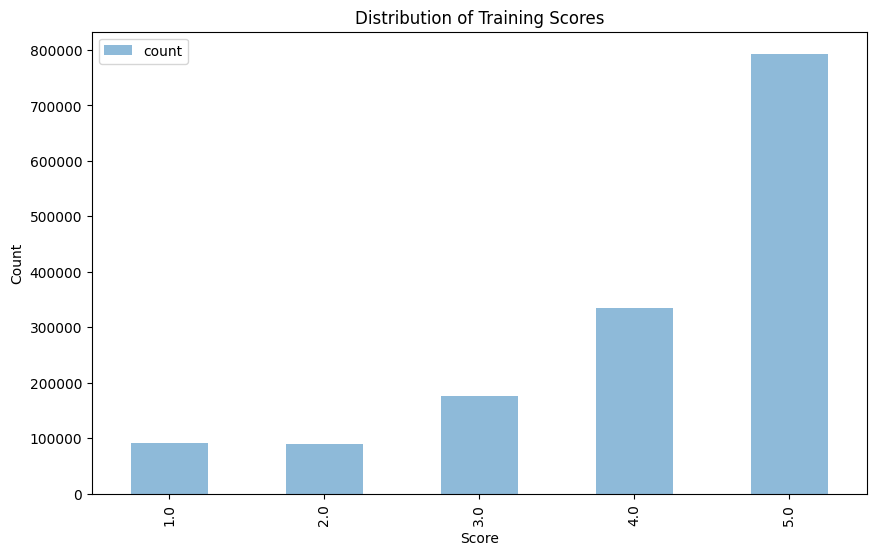


Training Score Distribution:
1.0    0.061393
2.0    0.060375
3.0    0.118547
4.0    0.225691
5.0    0.533994
Name: proportion, dtype: float64

Predicted Score Distribution:
1.0    0.023281
2.0    0.000730
3.0    0.018978
4.0    0.072175
5.0    0.884835
Name: proportion, dtype: float64


3927

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack, csr_matrix, vstack
import gc
import re
import warnings
warnings.filterwarnings('ignore')

def clean_text(text):
    """Basic text cleaning"""
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        return ' '.join(text.split())
    return ''

def process_in_batches(df, batch_size=10000):
    """Process dataframe in batches to conserve memory"""
    for start in range(0, len(df), batch_size):
        end = min(start + batch_size, len(df))
        yield df.iloc[start:end]

def create_features(df):
    """Create numerical features"""
    features = pd.DataFrame()
    features['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, 1)
    features['time_norm'] = (df['Time'] - df['Time'].min()) / (df['Time'].max() - df['Time'].min())
    return csr_matrix(features.fillna(0))

print("Loading data...")
train_df = pd.read_csv("/content/train.csv", engine="python")
test_df = pd.read_csv("/content/test.csv")

test_ids = test_df['Id'].values

print("\nInitializing text vectorizer...")
vectorizer = HashingVectorizer(
    n_features=1200,
    stop_words='english',
    ngram_range=(1, 2)
)

model = SGDClassifier(
    loss='modified_huber',
    penalty='l2',
    alpha=1e-4,
    max_iter=100,
    tol=1e-3,
    random_state=42,
    n_jobs=-1
)

print("\nProcessing training data in batches...")
X_train_sparse = None
y_train = []
batch_size = 10000

for batch in process_in_batches(train_df[~train_df['Id'].isin(test_ids)], batch_size):
    text = batch['Text'].fillna('') + ' ' + batch['Summary'].fillna('')
    text = [clean_text(t) for t in text]
    text_features = vectorizer.transform(text)

    num_features = create_features(batch)

    batch_features = hstack([num_features, text_features])

    if X_train_sparse is None:
        X_train_sparse = batch_features
    else:
        X_train_sparse = vstack([X_train_sparse, batch_features])

    y_train.extend(batch['Score'].values)

    gc.collect()

y_train = np.array(y_train)

print("\nProcessing test data...")
test_text = test_df.merge(train_df[['Id', 'Text', 'Summary', 'Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator']],
                         on='Id', how='left')

text = test_text['Text'].fillna('') + ' ' + test_text['Summary'].fillna('')
text = [clean_text(t) for t in text]
test_text_features = vectorizer.transform(text)
test_num_features = create_features(test_text)
X_test_sparse = hstack([test_num_features, test_text_features])

print("\nSplitting data for validation...")
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_sparse, y_train, test_size=0.2, random_state=42,
)

print("\nTraining model...")
model.fit(X_train_final, y_train_final)

print("\nEvaluating model...")
val_pred = model.predict(X_val)
print("\nValidation Metrics:")
print("Accuracy:", accuracy_score(y_val, val_pred))
print("\nClassification Report:")
print(classification_report(y_val, val_pred))

print("\nMaking predictions...")
test_predictions = model.predict(X_test_sparse)

submission = pd.DataFrame({
    'Id': test_ids,
    'Score': test_predictions
})
submission.to_csv("submission.csv", index=False)
print("\nSubmission file created!")

plt.figure(figsize=(10, 6))
pd.Series(y_train).value_counts().sort_index().plot(
    kind='bar',
    legend=True,
    alpha=0.5,
    title='Distribution of Training Scores'
)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Training Scores')
plt.show()

print("\nTraining Score Distribution:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())
print("\nPredicted Score Distribution:")
print(pd.Series(test_predictions).value_counts(normalize=True).sort_index())

gc.collect()